In [24]:
import os
import re
import sys
import json
import codecs
import locale
import logging
import requests
from enum import Enum
import datetime as dt
from typing import Union, Optional, Tuple, List, cast

from matplotlib import pyplot as plt    # type: ignore  
import matplotlib.gridspec as gridspec  # type: ignore 
import matplotlib.dates as mdates       # type: ignore


import pandas as pd
import numpy as np


#----------------------------------------------------------------
# Import the procedures that download and transform the pdf file
# into a dataframe.
#----------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..','src'))
common_path = os.path.abspath(os.path.join('..','src','common'))
print("{p2} {p1}".format(p1=common_path, p2=module_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(common_path)

from common.logger_init     import init_logger    
from common.result_value    import ResultValue, ResultOk, ResultKo    
from common.ChartTools      import set_axes_common_properties 
from common.ChartTools      import remove_tick_lines 
from common.ChartTools      import autolabel 


/Users/ERIZZAG5J/repos/JMeter_report/src /Users/ERIZZAG5J/repos/JMeter_report/src/common


In [2]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

temp_content_dir = os.path.join(os.sep, 'tmp')
images_path = os.path.join("..","images")

now = dt.datetime.now()
sample_date = now.strftime("%d/%m/%Y")

locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

ok_statuses = [200, 201, 202]
data_file_path = os.path.join(os.sep,"Users","ERIZZAG5J","Work","jmeter")
data_file_name = "merge_file.jtl"
csv_data_file = os.path.join(data_file_path, data_file_name)

image_file_prefix = "Test-"

class TypeOfOutputChart(Enum):
    PDF = 1
    PNG = 2
    JPG = 3

output_chart_type = TypeOfOutputChart.JPG

In [3]:
dtype_dict: dict = {'asset_id':str}
df = pd.read_csv(csv_data_file,low_memory=False, dtype=dtype_dict
                ,sep='#')  
df["timeStamp"] = pd.to_datetime(df["timeStamp"])
df.set_index("timeStamp", inplace=True)
(df.shape[0],df.dtypes)

(783449,
 elapsed              int64
 label               object
 responseCode         int64
 responseMessage     object
 threadName          object
 dataType            object
 success               bool
 failureMessage      object
 bytes                int64
 sentBytes            int64
 grpThreads           int64
 allThreads           int64
 URL                 object
 Filename           float64
 Latency              int64
 SampleCount          int64
 ErrorCount           int64
 Hostname            object
 IdleTime             int64
 Connect              int64
 asset_id            object
 CACHE_HIT          float64
 dtype: object)

In [4]:
max_elapsed = 300
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'responseCode', 'elapsed','responseCode']]
unacceptable_elapsed.sort_values('elapsed', ascending=False).head(10)

,asset_id,responseCode,elapsed,responseCode
timeStamp,,,,
2022-03-10 16:28:37.031000,1052,200,11304,200
2022-03-10 16:28:37.041400,1056,200,10803,200
2022-03-10 16:28:37.036000,1053,200,10569,200
2022-03-10 16:27:28.080800,24,200,10538,200
2022-03-10 16:35:54.019700,1086,200,10352,200
2022-03-10 16:35:54.020400,1090,200,10346,200
2022-03-10 16:27:29.064300,56,200,10342,200
2022-03-10 16:47:14.081700,53,200,10335,200
2022-03-10 16:35:54.019700,1087,200,10328,200


In [5]:
mask = (df["failureMessage"].str.contains("Expected to find an object") == True)
wrong_response = df.loc[mask,['asset_id', 'elapsed','failureMessage']]
print("Avg: {avg}".format(avg=wrong_response['elapsed'].mean()))
wrong_response.sort_values('elapsed', ascending=False).head(10)

Avg: 1359.4235416869749


,asset_id,elapsed,failureMessage
68075,392961,30139,Expected to find an object with property ['hls...
745443,180751,30132,Expected to find an object with property ['hls...
745444,191746,30126,Expected to find an object with property ['hls...
765881,300398,30125,Expected to find an object with property ['hls...
745445,191749,30123,Expected to find an object with property ['hls...
722076,369433,30111,Expected to find an object with property ['hls...
745442,191750,30104,Expected to find an object with property ['hls...
765844,216654,30102,Expected to find an object with property ['hls...
769432,320979,30101,Expected to find an object with property ['hls...
722057,366415,30100,Expected to find an object with property ['hls...


Time (less than 220): 591287 - (more than 220): 189069
Hit: 0 - Miss: 0


/var/folders/ny/gwc3ss8d6w9bsgvbdll9dw5m0000gq/T/ipykernel_51368/2006893512.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(x, rotation=80)
/var/folders/ny/gwc3ss8d6w9bsgvbdll9dw5m0000gq/T/ipykernel_51368/2006893512.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(x, rotation=80)


Errore - 'list' object has no attribute 'spines'


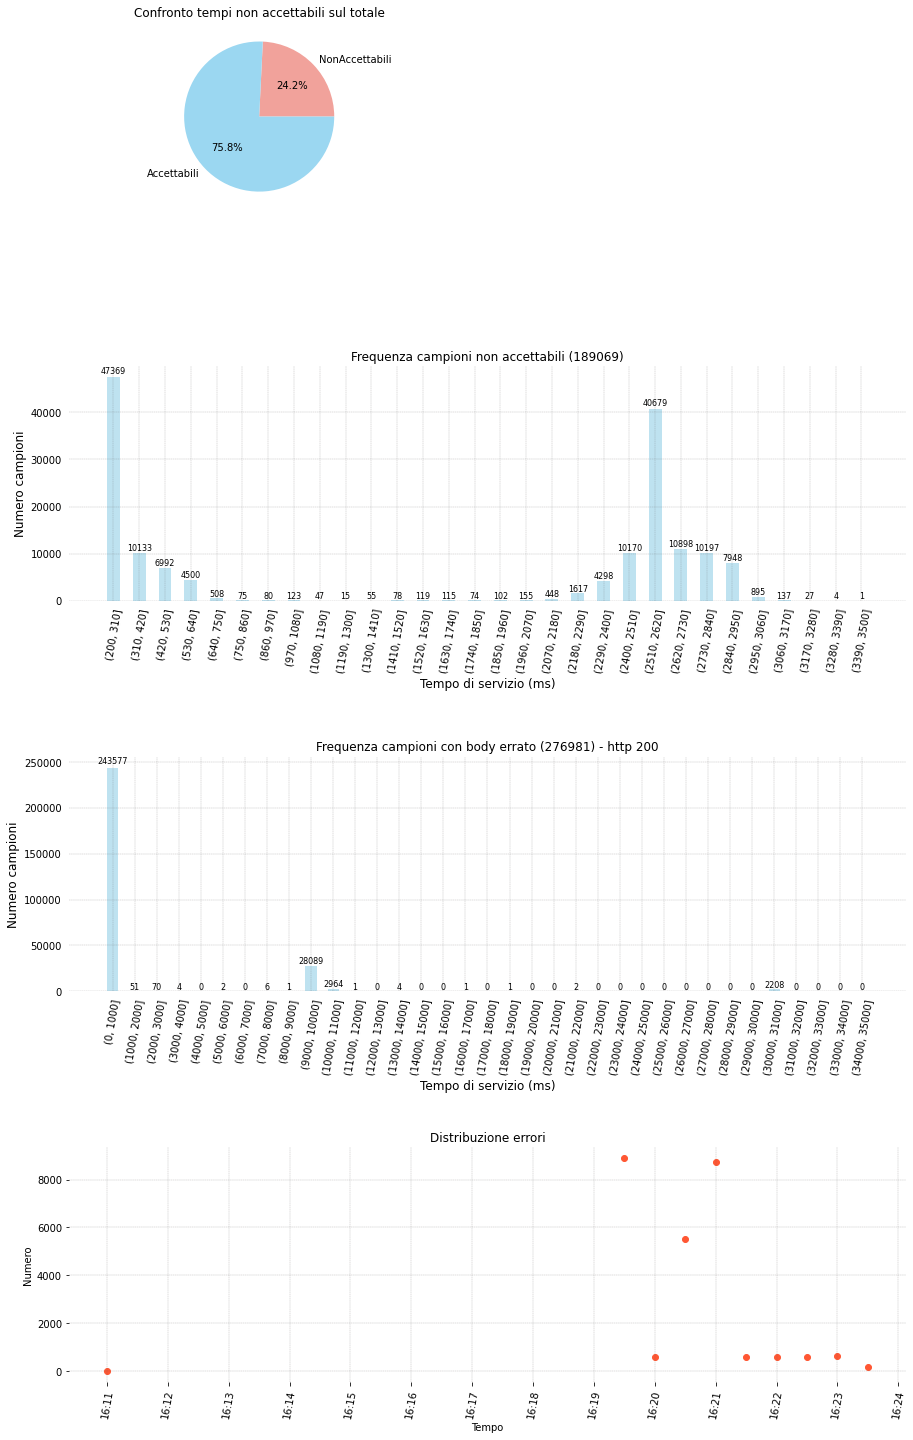

In [30]:
# --------------------------------------------------------------
# CONFIG SECTION
# --------------------------------------------------------------
max_elapsed = 220
cache_chart = False
frequency_chart = True
error_frequency_chart = True
error_dist_chart = True

# --------------------------------------------------------------
# DATA SECTION
# --------------------------------------------------------------
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'elapsed','responseCode']]
unacceptable_elapsed_num = unacceptable_elapsed.shape[0]

mask = (df["responseCode"] == 200)
total_transactions = df.loc[mask,:].shape[0]
acceptable_num = total_transactions - unacceptable_elapsed_num

print("Time (less than {t}): {ok} - (more than {t}): {ko}".format(ok=acceptable_num, ko=unacceptable_elapsed_num,t=max_elapsed))

# --------------------------------------------------------------
mask = (df["CACHE_HIT"] == "Miss") & (df["responseCode"] == 200) & (df['CACHE_HIT'].notnull())
miss_num = df.loc[mask,"CACHE_HIT"].shape[0]
mask = (df["CACHE_HIT"] == "Hit") & (df["responseCode"] == 200) & (df['CACHE_HIT'].notnull())
hit_num = df.loc[mask,"CACHE_HIT"].shape[0]

print("Hit: {hit} - Miss: {miss}".format(hit=hit_num, miss=miss_num))

# --------------------------------------------------------------
mask = (df["elapsed"] > max_elapsed) & (df["responseCode"] == 200)
unacceptable_elapsed = df.loc[mask,['asset_id', 'elapsed','responseCode']]
fr_num = unacceptable_elapsed.shape[0]
cut_bins = list(range(200, 3600, 110))
unacceptable_elapsed['elapsed binned'] = pd.cut(unacceptable_elapsed['elapsed'], bins=cut_bins, right=True)
frequencies = unacceptable_elapsed['elapsed binned'].value_counts(sort=False)

# --------------------------------------------------------------
mask = (df["failureMessage"].str.contains("Expected to find an object") == True)
wrong_response = df.loc[mask,['asset_id', 'elapsed','failureMessage']]
cut_bins = list(range(0, 36000, 1000))
wrong_response['elapsed binned'] = pd.cut(wrong_response['elapsed'], bins=cut_bins, right=True)
wr_frequencies = wrong_response['elapsed binned'].value_counts(sort=False)
wr_num = wrong_response.shape[0]

# --------------------------------------------------------------
time_delta = 30
time_unit = 'S'
td_for_grouper = '{td}{tu}'.format(td=str(time_delta), tu=time_unit)
wr_binned_elapsed = wrong_response.groupby(pd.Grouper(level='timeStamp', freq=td_for_grouper))['elapsed'].agg(['count'])

mask = (wr_binned_elapsed['count'].notnull())&(wr_binned_elapsed['count'] > 0)
errors_ts = wr_binned_elapsed.loc[mask,:].head(10)

# --------------------------------------------------------------
# CHART SECTION
# --------------------------------------------------------------
fig = plt.figure(figsize=(15, 25))
gs1 = gridspec.GridSpec(4, 2
                       ,figure=fig 
                       ,hspace=0.7
                       ,wspace=0.2
                       ,height_ratios=[8, 10, 10, 10]
                       ,width_ratios=[10, 10])
ax = []
idx = 0
ax.append(fig.add_subplot(gs1[0,0]))

labels = ["NonAccettabili", "Accettabili"]

acceptable_color = "#f1a29b"
unacceptable_color = "#9bd7f1"
chart_unacc_acc = [unacceptable_elapsed_num, acceptable_num]

ax[idx].pie(chart_unacc_acc, labels=labels, colors=[acceptable_color, unacceptable_color], autopct='%1.1f%%')
ax[idx].set_title("Confronto tempi non accettabili sul totale", fontsize=12)

if cache_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[0,1]))

    labels = ["Hit", "Miss"]
    chart_hit_miss = [hit_num, miss_num]
    hit_color = "#9bd7f1"
    miss_color = "#f1a29b"

    ax[idx].pie(chart_hit_miss, labels=labels, colors=[hit_color, miss_color], autopct='%1.1f%%')
    ax[idx].set_title("Hit / Miss", fontsize=12)

if frequency_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[1,:]))

    y = frequencies
    x = frequencies.index.astype(str)
    set_axes_common_properties(ax[idx], no_grid=False)
    ax[idx].set_title("Frequenza campioni non accettabili ({n})".format(n=fr_num), fontsize=12)
    ax[idx].set_ylabel("Numero campioni", fontsize=12)
    ax[idx].set_xlabel("Tempo di servizio (ms)", fontsize=12)
        
    width = 0.5
    colors = ["#BEE2F0", "#d5d5d5", "#c87607"]
    rects = ax[idx].bar(x, y, width=width, color=colors[0], label="elapsed-frequency label")
    ax[idx].set_xticklabels(x, rotation=80)
    remove_tick_lines('y', ax[idx])
    remove_tick_lines('x', ax[idx])
    autolabel(rects, ax[idx], 1)

if error_frequency_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[2,:]))

    y = wr_frequencies
    x = wr_frequencies.index.astype(str)
    set_axes_common_properties(ax[idx], no_grid=False)
    ax[idx].set_title("Frequenza campioni con body errato ({n}) - http 200".format(n=wr_num), fontsize=12)
    ax[idx].set_ylabel("Numero campioni", fontsize=12)
    ax[idx].set_xlabel("Tempo di servizio (ms)", fontsize=12)
        
    width = 0.5
    colors = ["#BEE2F0", "#d5d5d5", "#c87607"]
    rects = ax[idx].bar(x, y, width=width, color=colors[0], label="elapsed-frequency label")
    ax[idx].set_xticklabels(x, rotation=80)
    remove_tick_lines('y', ax[idx])
    remove_tick_lines('x', ax[idx])
    autolabel(rects, ax[idx], 1)    

if error_dist_chart == True:
    idx += 1
    ax.append(fig.add_subplot(gs1[3,:]))

    minutes = mdates.MinuteLocator(interval = 1)
    minutes_fmt = mdates.DateFormatter('%H:%M')

    set_axes_common_properties(ax, no_grid=False)
    ax[idx].xaxis.set_major_locator(minutes)
    ax[idx].xaxis.set_major_formatter(minutes_fmt)
    ax[idx].tick_params(axis='x', labelrotation=80)
    
    ax[idx].set_title("Distribuzione errori", fontsize=12)
    ax[idx].set_ylabel("Numero", fontsize=10)
    ax[idx].set_xlabel("Tempo", fontsize=10)
    
    x = errors_ts.index
    y = errors_ts['count']
    set_axes_common_properties(ax[idx], no_grid=False)
    
    ax[idx].scatter(x, y, color="#FF5733")


        

In [16]:
mask = (df["failureMessage"].str.contains("Expected to find an object") == True)
wrong_response = df.loc[mask,['asset_id', 'elapsed','failureMessage']]


time_delta = 30
time_unit = 'S'
td_for_grouper = '{td}{tu}'.format(td=str(time_delta), tu=time_unit)
wr_binned_elapsed = wrong_response.groupby(pd.Grouper(level='timeStamp', freq=td_for_grouper))['elapsed'].agg(['count'])

mask = (wr_binned_elapsed['count'].notnull())&(wr_binned_elapsed['count'] > 0)
wr_binned_elapsed.loc[mask,:].head(10)
#(wr_binned_elapsed.shape[0],wr_binned_elapsed.dtypes)

,count
timeStamp,
2022-03-10 16:11:00,1
2022-03-10 16:19:30,8906
2022-03-10 16:20:00,595
2022-03-10 16:20:30,5500
2022-03-10 16:21:00,8727
2022-03-10 16:21:30,600
2022-03-10 16:22:00,601
2022-03-10 16:22:30,581
2022-03-10 16:23:00,614


In [5]:
df["threadName"].unique()

array(['node-02 setUp Thread Group 1-1', 'node-02 Auth token 1-1',
       'node-02 Playback 2-1', 'node-02 Playback 2-2',
       'node-02 Playback 2-3', 'node-02 Playback 2-4',
       'node-02 Playback 2-5', 'node-02 Playback 2-6',
       'node-02 Playback 2-7', 'node-02 Playback 2-8',
       'node-02 Playback 2-9', 'node-02 Playback 2-10',
       'node-02 Playback 2-11', 'node-02 Playback 2-12',
       'node-02 Playback 2-13', 'node-02 Playback 2-14',
       'node-02 Playback 2-15', 'node-02 Playback 2-16',
       'node-02 Playback 2-17', 'node-02 Playback 2-18',
       'node-02 Playback 2-19', 'node-02 Playback 2-20',
       'node-02 Playback 2-21', 'node-02 Playback 2-22',
       'node-02 Playback 2-23', 'node-02 Playback 2-24',
       'node-02 Playback 2-25', 'node-02 Playback 2-26',
       'node-02 Playback 2-27', 'node-02 tearDown Thread Group 1-1',
       'node-03 setUp Thread Group 1-1', 'node-03 Auth token 1-1',
       'node-03 Playback 2-1', 'node-03 Playback 2-2',
       'no

In [5]:
df.loc[:,["threadName","grpThreads","allThreads"]]

,threadName,grpThreads,allThreads
0,node-02 setUp Thread Group 1-1,1,1
1,node-02 setUp Thread Group 1-1,1,1
2,node-02 Auth token 1-1,1,1
3,node-02 Auth token 1-1,1,1
4,node-02 Playback 2-1,1,2
...,...,...,...
8567069,node-03 Playback 2-18,4,4
8567070,node-03 Playback 2-24,3,3
8567071,node-03 Playback 2-20,2,2
8567072,node-03 Playback 2-25,1,1


In [9]:
df.loc[:,"threadName"].unique()

array(['node-01 Manifest 1-1', 'node-01 Manifest 1-2',
       'node-01 Manifest 1-3', 'node-01 Manifest 1-4',
       'node-01 Manifest 1-5', 'node-01 Manifest 1-6',
       'node-01 Manifest 1-7', 'node-01 Manifest 1-8',
       'node-01 Manifest 1-9', 'node-01 Manifest 1-10',
       'node-01 Manifest 1-11', 'node-01 Manifest 1-12',
       'node-01 Manifest 1-13', 'node-01 Manifest 1-14',
       'node-01 Manifest 1-15', 'node-01 Manifest 1-16',
       'node-01 Manifest 1-17', 'node-01 Manifest 1-18',
       'node-01 Manifest 1-19', 'node-01 Manifest 1-20',
       'node-01 Manifest 1-21', 'node-01 Manifest 1-22',
       'node-01 Manifest 1-23', 'node-01 Manifest 1-24',
       'node-01 Manifest 1-25', 'node-01 Manifest 1-26',
       'node-01 Manifest 1-27', 'node-01 Manifest 1-28',
       'node-01 Manifest 1-29', 'node-01 Manifest 1-30',
       'node-01 Manifest 1-31', 'node-01 Manifest 1-32',
       'node-01 Manifest 1-33', 'node-01 Manifest 1-34',
       'node-01 Manifest 1-35', 'node-01